In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
import random
import numpy as np
import pandas as pd
from sklearn import datasets, svm, cross_validation, tree, preprocessing, metrics
import sklearn.ensemble as ske

In [4]:
df = pd.read_csv('train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
#get total percentage of survived
df['Survived'].mean()

0.38383838383838381

In [6]:
#group by passenger class with sex
class_sex_grouping = df.groupby(['Pclass','Sex']).mean()
class_sex_grouping

PassengerId  Survived        Age     SibSp     Parch  \
Pclass Sex                                                            
1      female   469.212766  0.968085  34.611765  0.553191  0.457447   
       male     455.729508  0.368852  41.281386  0.311475  0.278689   
2      female   443.105263  0.921053  28.722973  0.486842  0.605263   
       male     447.962963  0.157407  30.740707  0.342593  0.222222   
3      female   399.729167  0.500000  21.750000  0.895833  0.798611   
       male     455.515850  0.135447  26.507589  0.498559  0.224784   

                     Fare  
Pclass Sex                 
1      female  106.125798  
       male     67.226127  
2      female   21.970121  
       male     19.741782  
3      female   16.118810  
       male     12.661633

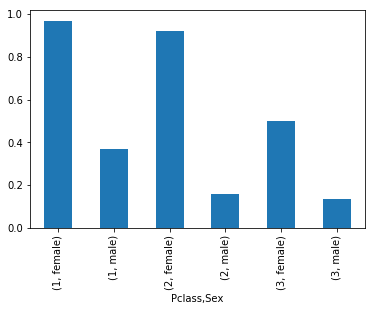

In [7]:
class_sex_grouping['Survived'].plot.bar()

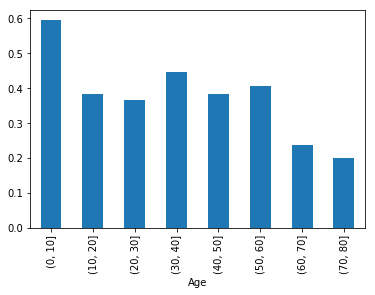

In [8]:
#group by age with range of 10
group_by_age = pd.cut(df["Age"], np.arange(0, 90, 10))
age_grouping = df.groupby(group_by_age).mean()
age_grouping['Survived'].plot.bar()

In [9]:
#lookout for any missing value
df.count()

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64

In [7]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
'''
1. passenger id is just an id generated by data set
2. ticket: maybe a group of ticket have higher chances
3. cabin : maybe location of cabin determined higher or lower chances
4. fare  : related with ticket?
5. name  : certain group of people, certain group of rank (eg: Mr, Mrs, Counte?) hv higher rate?
'''
df = df.drop(['PassengerId','Ticket','Cabin','Fare','Name'], axis=1)
df.head()

In [10]:
# drop Na values if available, not a good choice but will do for now
# alternative : replace na value with average, estimate va values by linear regression?
df = df.dropna()

#check if every column got same value, thus implying no missing values
df.count()

Survived    712
Pclass      712
Name        712
Sex         712
Age         712
SibSp       712
Parch       712
Embarked    712
dtype: int64

In [12]:
'''
The “sex” and “embarked” fields are both string values that correspond to categories (i.e “Male” and “Female”)
so we will run each through a preprocessor. This preprocessor will convert these strings into integer keys, 
making it easier for the classification algorithms to find patterns. 
For instance, “Female” and “Male” will be converted to 0 and 1 respectively.
'''

def preProcessDf(df):
    processed_df = df.copy()
    le = preprocessing.LabelEncoder()
    processed_df.Sex = le.fit_transform(processed_df.Sex)
    processed_df.Embarked = le.fit_transform(processed_df.Embarked)
    return processed_df

In [13]:
df = preProcessDf(df)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked
0,0,3,1,22.0,1,0,2
1,1,1,0,38.0,1,0,0
2,1,3,0,26.0,0,0,2
3,1,1,0,35.0,1,0,2
4,0,3,1,35.0,0,0,2


In [14]:
'''
Next, we separate the data set into two arrays: “X” containing all of the values for each row besides “survived”, 
and “y” containing only the “survived” value for that row. The classification algorithms will compare the 
attribute values of “X” to the corresponding values of “y” to detect patterns in how different attributes values 
tend to affect the survival of a passenger.

Finally, we break the “X” and “y” array into two parts each — a training set and a testing set. 
We will feed the training set into the classification algorithm to form a trained model. 
Once the model is formed, we will use it to classify the testing set, allowing us to determine the accuracy of the 
model. Here we have have made a 20/80 split, such that 80% of the dataset will be used for training and 20% will 
be used for testing.

'''


X = df.drop(['Survived'], axis=1).values
y = df['Survived'].values

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y,test_size=0.2)

In [15]:
clf_dt = tree.DecisionTreeClassifier(max_depth=10)

In [16]:
clf_dt.fit (X_train, y_train)
clf_dt.score (X_test, y_test)

0.76223776223776218

In [17]:
shuffle_validator = cross_validation.ShuffleSplit(len(X), n_iter=20, test_size=0.2, random_state=0)

In [18]:
def test_classifier(clf):
    scores = cross_validation.cross_val_score(clf, X, y, cv=shuffle_validator)
    print("Accuracy: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std()))

In [19]:
test_classifier(clf_dt)

Accuracy: 0.7846 (+/- 0.03)


In [20]:
clf_rf = ske.RandomForestClassifier(n_estimators=50)
test_classifier(clf_rf)

Accuracy: 0.7937 (+/- 0.02)


In [21]:
clf_gb = ske.GradientBoostingClassifier(n_estimators=50)
test_classifier(clf_gb)

Accuracy: 0.8157 (+/- 0.03)


In [22]:
eclf = ske.VotingClassifier([('dt', clf_dt), ('rf', clf_rf), ('gb', clf_gb)])
test_classifier(eclf)

Accuracy: 0.8045 (+/- 0.02)
